<a href="https://colab.research.google.com/github/AmlanSamanta/FineTuningLLMs/blob/main/GPT_2_Fine_Tuning_w_Hugging_Face_%26_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.5 MB/s eta 0:00:00


In [2]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [3]:
!nvidia-smi

Sun Apr 16 19:02:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
filename = '/content/drive/MyDrive/ra_top_1000_data_set.csv'
data_dir = '/content/drive/MyDrive/fineTunedGPT2'

In [5]:
df = pd.read_csv(filename)  
print(df)

      Unnamed: 0                                                bio
0              0  When it funks, it funks hard.\n\nBreaking Beat...
1              1  "Purposively ricocheting between the techno wo...
2              2  Acid Arab is a duet from Paris whose goal is t...
3              3  Over the last 20 years Martin Gretschmann has ...
4              4                                                NaN
...          ...                                                ...
1009        1009  Life is hard but music is good!As a music enth...
1010        1010  When one could assume, &ME entered the House a...
1011        1011  From politically incorrect prog-rock to funky ...
1012        1012  Techno from outer space999999999 -officially s...
1013        1013  Singer, songwriter, rapper, house and techno D...

[1014 rows x 2 columns]


In [6]:
df.dropna(inplace=True)
bios = df.bio.copy()
bios

0       When it funks, it funks hard.\n\nBreaking Beat...
1       "Purposively ricocheting between the techno wo...
2       Acid Arab is a duet from Paris whose goal is t...
3       Over the last 20 years Martin Gretschmann has ...
5       Her legendary live shows took her once around ...
                              ...                        
1009    Life is hard but music is good!As a music enth...
1010    When one could assume, &ME entered the House a...
1011    From politically incorrect prog-rock to funky ...
1012    Techno from outer space999999999 -officially s...
1013    Singer, songwriter, rapper, house and techno D...
Name: bio, Length: 802, dtype: object

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
print("The maximum model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} and token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} and has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} and has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The maximum model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> and token has the id 50257
The end of sequence token <|endoftext|> and has the id 50256
The padding token <|pad|> and has the id 50258


In [9]:
batch_size = 2
class CustomDataset(Dataset):
  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [10]:
dataset = CustomDataset(bios, tokenizer, max_length=768)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  721 training samples
   81 validation samples


In [11]:
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [12]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [13]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)
                                            

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [15]:
total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training section
    # ========================================

    print("")
    print('======== Running Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Running Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]
        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation Section
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training completed!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Running Epoch 1 / 5 ========
Running Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    361. Loss: 3.365485906600952.   Elapsed: 0:00:49.
0:  bipartisan" statehouse.com— – October first weekend since becoming the most prominent US music radio DJ, and now having achieved rave reviews across Europe with music labels like Pipes & Cloves and Radiohead. Since the launch of the single "The Dancefloor", he has gone to great lengths to stay in shape and improve his music career. In 2005, he released a remix compilation CD "The Sound of the Wave", which became his most respected record. Later, he was part of the duo "Violet's Music" EP and had a remix compilation CD "The Sound of the Wave". With the release of the record "Stolen Light and Sunshine", which made him a star internationally. His remix-album "Lust for Life" also contributed to his record "Escape From the Machine" where he had one of his best albums, releasing his breakthrough EP "Born to Beat - EP 10".

With his remix-album "Escape from the Machine", he


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    361. Loss: 0.1623915731906891.   Elapsed: 0:01:46.
0:  increasingSicheria di Scouse, from Italy.

In 1998 he took a trip to the UK. He found himself in an increasingly unfamiliar city with a young population that began to clamor for his next gig at a radio station called the Good Times. Although she was at the station, he spent his first week at St George Magazines playing several of the station's many shows. Afterward, he moved to Europe in 2006 as a resident of the UK with his parents. When he returned home, he was met with widespread’s fascination with dance music. After spending the next two years in Europe, he started his first gigs in clubs across Europe.

”


”


”
 music is something unique

 and its influence can only be seen through the music of a handful of labels:

.


.
 music is something unique and it's influence can only be seen through the music


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    361. Loss: 1.7591272592544556.   Elapsed: 0:02:42.
0: day" as an "uncredited" performer. "My first official production came in 1994, when it was called 'Cage of My Dreams' by a handful of producers from around the world. It was the first electronic dance music project I ever wanted to make. It took place in the basement of the small house and techno clubs in London, England in 1996 – then as far away as Germany – and it is something that I am most proud of - as both a music lover and a producer. It's a mixture of the techno and dancehall of early industrial music. My productions, alongside the vast output of the first two albums, were a joy to watch. They followed with a series of sets that culminated in a highly acclaimed solo performance. The subsequent series followed with a string of sets, including several classic remixes. But before long, a string of other projects began, including solo productions by The Beatles - as well as a remix for a popular house duo -

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    361. Loss: 2.2247064113616943.   Elapsed: 0:00:53.
0:  HangDoris and Gennaro’s second collaboration, "Tribal" is a collaborative album by Dybald, released in 2015. Dybald’s third studio album was released in 2016. Tribal is an effort by Dybald and the Black Sheep Productions team to build an audio collective into an integral part of the Black Sheep's ongoing effort to find solutions for the world’s biggest music conundrum.

‘Do I need techno or disco?’


As the Black Sheep team prepares to play in a highly anticipated 4/4 set at the Biltmore Festival, Dybald reveals that he has a special love of techno and disco’s "dark side." That’s where the Black Sheep's focus lies. As Dybald explains:


“I need techno and disco, and I don’t want techno and disco. We need hip hop and stuff and stuff like


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    361. Loss: 1.9661704301834106.   Elapsed: 0:01:47.
0:  foodsAs a name for people like Mike Shannon, his own alias is synonymous with techno, but he's always been an artist who draws inspiration from obscure, unknown and unlikely locations. Starting off as a DJ, Mike has steadily gained popularity in his hometown. As of 2009, he is playing on nearly all of the major festivals including DC10, Fuse and the Glastonbury Festival, taking in almost every club and festival. 
Mike Shannon also runs the legendary ‘Lush’ label which he runs from his home on South Harbour and operates with his own label. His output spans more than just the legendary ‘Techno and Techno’s as well as remixes and remixes, and features a mixture of sounds from artists like Steve Nash, Kevin Nash, Mike Huckaby, Mike Huckaby, The Pickle, Tsubu and many more. More recently, he’s launched ‘Culture’ (a website that allows listeners to download


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    361. Loss: 2.2518458366394043.   Elapsed: 0:02:43.
0:  trailFantastic! No problem!” (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)

Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic! No problem! (Robert Baker)
Fantastic!

  Average training loss: 2.01
  Training epoch took: 0:03:17

Running Validation...
  Validation Loss: 2.07
  Validation took: 0:00:07

======== Running Epoch 3 / 5 ========
Running Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    361. Loss: 2.9783053398132324.   Elapsed: 0:00:53.
0: intendFor years there have been few young producers that have made a living on music. For some they are young, they can play anywhere they like from home, a dancefloor party or techno party. For others they are old, they can play any position or profession they like. Some have been known to play for long periods of time. Others, from outer space to obscure and difficult places, have been very successful. The list goes on and on, and it keeps getting better and better.

But for this particular generation of young producers who have become so comfortable with the DJing that they are ready for the full spectrum of the crowd, there is no better time than now to declare them to be the next generation of talent. For them that means they are now a little more involved in the underground music scene than they were before they first met. And this means that the DJ culture that they have known since they were little has b

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    361. Loss: 1.7030466794967651.   Elapsed: 0:01:48.
0:  surroundThe artist behind 'Knee Deep' is a techno artist and producer from Sweden.
As with her previous productions “Crowned in the Realm of Sound” and “Undercover”, she is best known for her DJ sets. With her DJ set ‘Get Down’, she performs alongside legendary DJ Tiga & friends, along with two collaborations with Giegling (aka ‘Knee Deep”), and has been busy as a producer, remixer and remixer for two of ‘Planet Müs best known imprints including ‘Euphoria’; ‘Planet Müs Essential Mix’ and ‘Body Parts’. ‘Planet Müs Essential Mix’ showcases her signature signature grooves and tight flow through the ‘Planet Müs Essential Mix Vol’, an intimate club series with the best techno and rave scenes around the world. Also featured on


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    361. Loss: 1.5255709886550903.   Elapsed: 0:02:46.
0:  reflexIt sounds like there might be some sort of a weird convergence in genre, depending on who you ask, it is one of techno, electro, ambient or electro..It sounds like there might be some sort of a weird convergence in genre, depending on who you ask, it is one of techno, electro, ambient or electro

  Average training loss: 1.81
  Training epoch took: 0:03:18

Running Validation...
  Validation Loss: 2.08
  Validation took: 0:00:07

======== Running Epoch 4 / 5 ========
Running Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    361. Loss: 2.581862211227417.   Elapsed: 0:00:52.
0:  displaySophia Dee Dee is a New York City producer and DJ based in Brooklyn, New York. 
Her first record under the pseudonym 'Punch Drunk' was released on Ninja Tune in 1995, the title track being considered one of the finest Techno albums to come out at the time. She released the tracks 'Wonky Fool' and 'Can I Have It All', which were deemed classics in the scene by the scene. She soon followed that up with her debut album 'Diary Of A Sex Slave'. 'Punch Drunk', released in 1999, introduced her sound to the wider world. 
She released an album of classic Techno tracks 'Kicking Off' on Ninja Tune in 2000 and a few years later, her album 'Jealous Tennis', was released on Ninja Tune and included tracks from other Techno artists such as Maya Jane Coles, Maceo Plex, and Dave Clarke. She started her career on Soundcloud and recorded her first releases under the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    361. Loss: 1.404528260231018.   Elapsed: 0:01:47.
0:  pastorA DJ for many years, James Holden has earned a reputation as one of the most interesting electronic music producers of the current generation.His solo productions appear on many dance music labels, with his label, CLR, releasing only the most sought after releases. His DJ sets have been described as “Essential Techno” and “Essential Jungle”. His sets have featured in countless underground and commercial success stories, as well as a residency at New York’s legendary DC10. 

His DJ sets have also earned him support from numerous influential music industry figures, including The New York Times (co-founder of XLR8R), Pete Tong (owner of CLR), Chris Liebing (owner of Beats In Space) and Daniel Beyer (owner of CLR). 

As a label representative, CLR has released a number of high profile remixes for artists including Daniel Avery, Deeon, Bong Joon and Daniel Avery, alongside standout mixes from


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    361. Loss: 1.6950938701629639.   Elapsed: 0:02:43.
0:  illicitIn this context, it is very important for all producers to be connected through music to each other, having their own stories and concepts. Although the term 'genre' usually takes a broad genre to define it, it is most often used to describe a musical event or event. A certain point or style or scene can be very influential when it comes to the way the various parties and performers spin their music. Depending on who they are working with or their audience, it could include music by bands, DJs, fashion designers, journalists, and songbirds, all of which can be linked through the dance music label Verve.

DJ's, writers, sound artists, and label owners tend to have an influence on all the parties, artists and performers the most. nomads at an early age, influenced by music made from old films and picturesque landscapes, found their way into the clubs, bars and record shops of their adopted hometown of Detr

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    361. Loss: 2.287785291671753.   Elapsed: 0:00:53.
0:  LiberationRyne, known in New York as a dj from the south and Midwest, has spent most of her life in New York.Ryne is a true story. Born and raised in New York, this 6'5" queen of a movement that had its roots in Brooklyn, was soon discovered as one of the preeminent electronic music djs. A decade later, she would take to her first dance night at Rex Club and became the resident of one of the most prestigious venues in the world in the notorious Sater Club. Throughout her 15 years as a member of the legendary Sater Club circuit, she made it her mission to provide a safe environment for all the party goers to experience the true beauty of the East Village. There she also gave workshops on how to effectively run a label, running the dance floor brand Playhouse and hosting residencies at local locations like The Soup Kitchen, Fabric, The Loft, Tresor and Shelter, plus playing in venues all over New York


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    361. Loss: 1.5678479671478271.   Elapsed: 0:01:48.
0:  NamFamed for his knack for weaving dark, gritty industrial sounds with his signature voice, Dixon has been doing just that with his unique musical background. The German born & bred DJ has always been one to step outside the mainstream by taking his unique sound and imitating his unique sound and creative vision. Dixon has held residencies in the legendary Berlin club Berghain, Offenbach and many other key locations in his homeland.

As a producer & remixer, he has made music both deep and unique whilst still maintaining an open mind regarding music and culture. His discography includes tracks from The Black Madonna, Adam Beyer, Gilles Peterson, Marcel Dettmann, St Germain, Gilles Peterson and his own classic techno imprint.

In 2001, Dixon recorded his first album & a solo single on Detroit based label Warp Records. Alongside his solo productions and remixes, Dixon also released a number of artists with the la

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    361. Loss: 2.4347012042999268.   Elapsed: 0:02:43.
0: IONVINYL MASTER is a DJ, Producer, Live Act Producer and LIVE Act Producer with a production history spanning decades.

Vinyl masters include Kerri Chandler, David Lynch, Jeff Mills, Carl Craig, Nina Kraviz, Monolake, DJ Kreyg, Seth Troxler, Juan Atkins, Truncate, Ben Klock, Mark Lanegan, Ben Klockman, Chris Liebing, Daniel Bortz, Patrick Topping and more.

For more info contact: [email protected]

  Average training loss: 1.53
  Training epoch took: 0:03:15

Running Validation...
  Validation Loss: 2.14
  Validation took: 0:00:07

Training completed!
Total training took 0:16:57 (h:mm:ss)


In [16]:
pd.set_option("display.precision", 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.91,2.11,0:03:16,0:00:07
2,2.01,2.07,0:03:17,0:00:07
3,1.81,2.08,0:03:18,0:00:07
4,1.66,2.10,0:03:16,0:00:07
5,1.53,2.14,0:03:15,0:00:07


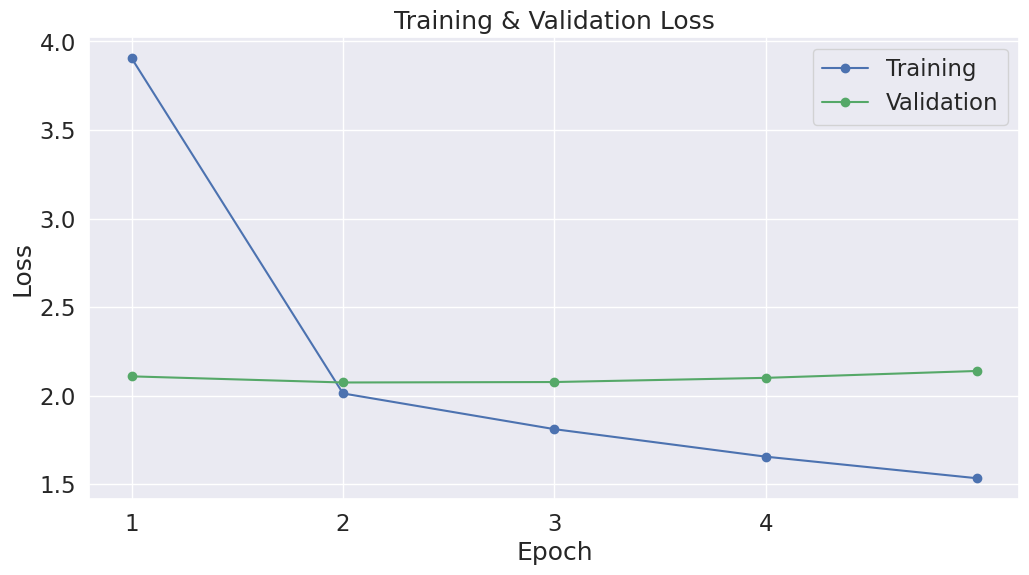

In [17]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [19]:
output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)


model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [20]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [21]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: “There’s only one person who has’t forgotten how much of an artist David Shoemaker is…” -Olivier Odier


1: Maurice Fulton is one of electronic music’s preeminent figures. Maurice Fulton grew up in the south of England, immersed in the rave scene as a teenager. 
Growing up, Maurice Fulton had an instinct for underground electronic music. From the age of 13, he began playing and learning to play bass drum, and later found his way into drum and bass drumming by picking up various records (his first record shop was in Chelmsford in the mid- seventies) and playing along. He was introduced to club music in the early nineties with his friend Jamie Jones and soon moved to Manchester to study percussion. At Manchester University he found his first DJing gig, on Saturday night he started to play bass drum. 
In the mid eighties, Maurice Fulton landed an invite to play with Adam Beyer's influential AfterHours record label. He got very excited about the chance